In [2]:
import os
import numpy as np
import pandas as pd
from scipy import fft, signal
from matplotlib import pyplot as plt
from tqdm import tqdm

import networkx as nx

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import cluster, linear_model, svm, neighbors, tree, ensemble

from torch import nn, optim, Tensor, LongTensor

from mne.io import read_raw_brainvision

In [3]:
data_dir = os.path.join('data', 'eeg64')
# unicorn_ch_names = ['Fz', 'CPz', 'C3', 'C4', 'Pz', 'PO7', 'PO8', 'Oz']  # wrong ones?
unicorn_ch_names = ['Fz', 'C3', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']  # no 'Cz'

# Load labels

In [5]:
subject = '02'

info = pd.read_csv(os.path.join(data_dir, f'sub-{subject}_task-rsvp_events.tsv'), delimiter='\t')
info.head()

,onset,duration,eventnumber,blocksequencenumber,isteststim,object,objectnumber,presentationnumber,sequencenumber,stim,...,teststimnumber,withinsequencenumber,istarget,stimname,response,rt,correct,time_stimon,time_stimoff,stimdur
0,38306,50,0,0,0,volleyball,1767,0,0,stimuli\volleyball\volleyball_08s.jpg,...,-1,0,0,volleyball_08s.jpg,0,0.0,0,26.493283,26.543261,0.049978
1,38406,50,1,0,0,tuxedo,1738,1,0,stimuli\tuxedo\tuxedo_04s.jpg,...,-1,0,0,tuxedo_04s.jpg,0,0.0,0,26.593286,26.643265,0.049979
2,38506,50,2,0,0,beetle,115,2,0,stimuli\beetle\beetle_05n.jpg,...,-1,0,0,beetle_05n.jpg,0,0.0,0,26.693289,26.743268,0.049979
3,38606,50,3,0,0,bracelet1,187,3,0,stimuli\bracelet1\bracelet1_01s.jpg,...,-1,0,0,bracelet1_01s.jpg,0,0.0,0,26.793301,26.843276,0.049975
4,38706,50,4,0,0,bouquet,173,4,0,stimuli\bouquet\bouquet_02s.jpg,...,-1,0,0,bouquet_02s.jpg,0,0.0,0,26.893289,26.943271,0.049982


In [6]:
info['objectnumber'].max()

1853

In [7]:
len(info), 1854 * 12

(24648, 22248)

In [8]:
info['object'].unique()[:20]

array(['volleyball', 'tuxedo', 'beetle', 'bracelet1', 'bouquet', 'ham',
       'tricycle', 'cigarette_holder', 'sparkler', 'tick', 'scale',
       'urinal', 'footbath', 'drain', 'printer', 'crayfish', 'projector',
       'barcode', 'pitcher', 'seagull'], dtype=object)

# Load EEG data

In [10]:
raw = read_raw_brainvision(os.path.join(data_dir, f'sub-{subject}_task-rsvp_eeg.vhdr'))
print(raw.ch_names)

Extracting parameters from data\eeg64\sub-02_task-rsvp_eeg.vhdr...
Setting channel info structure...
['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'AF8', 'AF4', 'F2', 'FCz']


In [11]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 63 EEG
 custom_ref_applied: False
 dig: 63 items (63 EEG)
 highpass: 0.0 Hz
 lowpass: 280.0 Hz
 meas_date: 2019-05-08 09:41:58 UTC
 nchan: 63
 projs: []
 sfreq: 1000.0 Hz
>

The data has 63 channels (64th is **Cz** used as an online reference) with 1000 Hz (lowpass 280 Hz). We will have 8 channels with 250 Hz (max freq is 125 Hz).

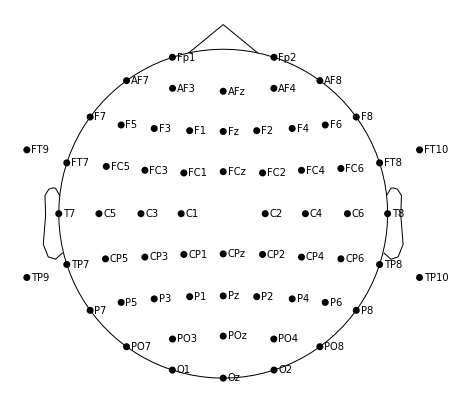

In [12]:
raw.plot_sensors(show_names=True);

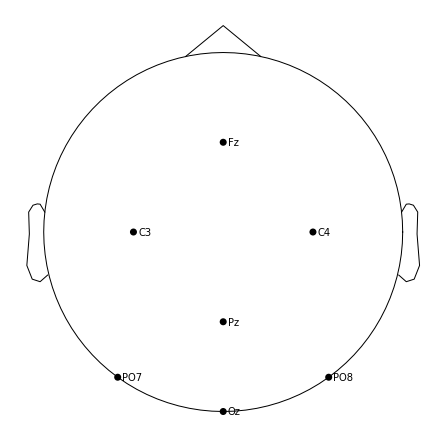

In [13]:
raw.pick_channels(unicorn_ch_names)
raw.plot_sensors(show_names=True);

In [14]:
unicorn_ch_names = raw.ch_names  # the correct arrangement of electrodes in data

Effective window size : 2.048 (s)


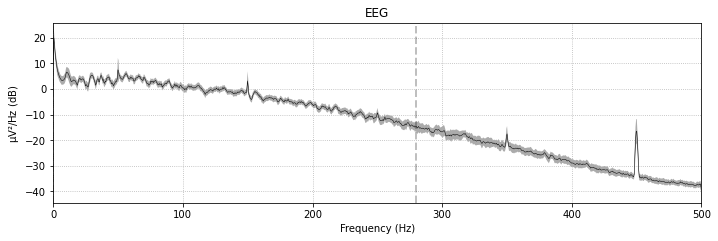

In [15]:
raw.plot_psd(average=True);

Reading 0 ... 3227279  =      0.000 ...  3227.279 secs...
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 125.00 Hz
- Upper transition bandwidth: 31.25 Hz (-6 dB cutoff frequency: 140.62 Hz)
- Filter length: 6601 samples (6.601

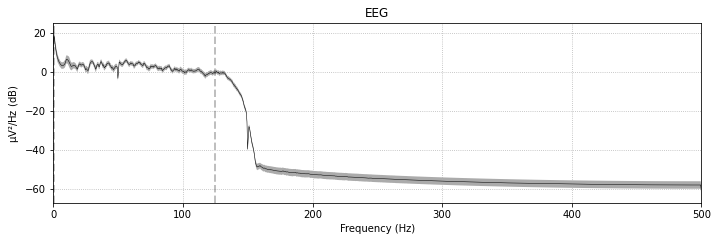

In [16]:
raw.load_data()
raw.notch_filter(freqs=[50, 150])  # higher ones are irrelevant because our top is 125 Hz
raw.filter(l_freq=0.5, h_freq=125)
raw.plot_psd(average=True);

In [17]:
data = raw.get_data()
data.shape

(7, 3227280)

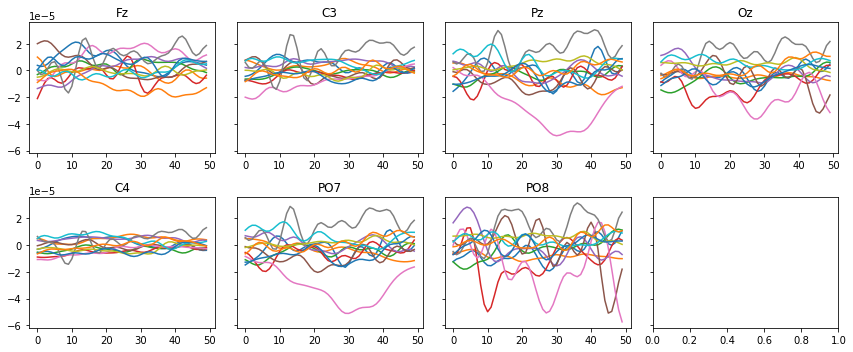

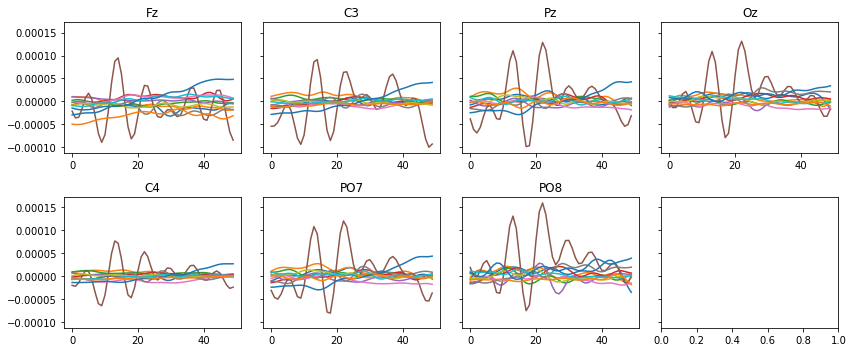

In [22]:
chosen_samples = {}

for object_name in ['aardvark', 'cabbage']:  # change to others
    chosen_samples[object_name] = []
    for i in info[info['object'] == object_name]['onset']:
        chosen_samples[object_name].append(data[:, i: i + 50])
  
    fig, axs = plt.subplots(2, 4, figsize=(12, 5), sharey=True)
    for ch_n, (ch_name, ax) in enumerate(zip(unicorn_ch_names, axs.ravel())):
        ax.set_title(ch_name)
        for s in chosen_samples[object_name]:
            ax.plot(s[ch_n])
    plt.tight_layout()
    plt.show()

Oz, PO7 and PO8 are quite active (vision).

What happenned with that one sample (in yellow) for "lettuce" in Fz?

# Unsupervised classification

In [25]:
methods = {
    'KMeans': cluster.KMeans(2),
    'Agg (w)': cluster.AgglomerativeClustering(2, linkage='ward'),
    'Agg (a)': cluster.AgglomerativeClustering(2, linkage='average'),
    'Agg (c)': cluster.AgglomerativeClustering(2, linkage='complete'),
    'Agg (s)': cluster.AgglomerativeClustering(2, linkage='single'),
    'Spc (r)': cluster.SpectralClustering(2, affinity='rbf', random_state=42),
    'Spc (n)': cluster.SpectralClustering(2, affinity='nearest_neighbors',
                                          random_state=42),  # best?
}

for ch_n, ch_name in enumerate(unicorn_ch_names):
    for method_name, method in methods.items():
        samples = [s[ch_n] for s in chosen_samples['aardvark'] + chosen_samples['cabbage']]
        method.fit(samples)
        preds = method.labels_
        
        true = np.array([0] * len(chosen_samples['aardvark']) + [1] * len(chosen_samples['cabbage']))
        true_inverse = np.abs(true - 1)
        correct = np.max([np.sum(preds == true), np.sum(preds == true_inverse)])
        if correct > 12:
            print(f'{ch_name} | {method_name}: \t{correct} ({correct / 24 * 100:.0f}%) good preds')
    print('-' * 20)

Fz | KMeans: 	16 (67%) good preds
Fz | Agg (w): 	17 (71%) good preds
Fz | Agg (a): 	13 (54%) good preds
Fz | Agg (c): 	14 (58%) good preds
Fz | Agg (s): 	13 (54%) good preds
Fz | Spc (r): 	17 (71%) good preds
Fz | Spc (n): 	13 (54%) good preds
--------------------
C3 | KMeans: 	13 (54%) good preds
C3 | Agg (w): 	13 (54%) good preds
C3 | Agg (a): 	13 (54%) good preds
C3 | Agg (c): 	13 (54%) good preds
C3 | Agg (s): 	13 (54%) good preds
C3 | Spc (r): 	13 (54%) good preds
C3 | Spc (n): 	15 (62%) good preds
--------------------
Pz | KMeans: 	13 (54%) good preds
Pz | Agg (w): 	13 (54%) good preds
Pz | Agg (a): 	13 (54%) good preds
Pz | Agg (c): 	13 (54%) good preds
Pz | Agg (s): 	13 (54%) good preds
Pz | Spc (n): 	15 (62%) good preds
--------------------
Oz | KMeans: 	13 (54%) good preds
Oz | Agg (w): 	13 (54%) good preds
Oz | Agg (a): 	13 (54%) good preds
Oz | Agg (c): 	13 (54%) good preds
Oz | Agg (s): 	13 (54%) good preds
Oz | Spc (r): 	15 (62%) good preds
Oz | Spc (n): 	16 (67%) good pr

C:\Users\user\miniconda3\envs\magister\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\user\miniconda3\envs\magister\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


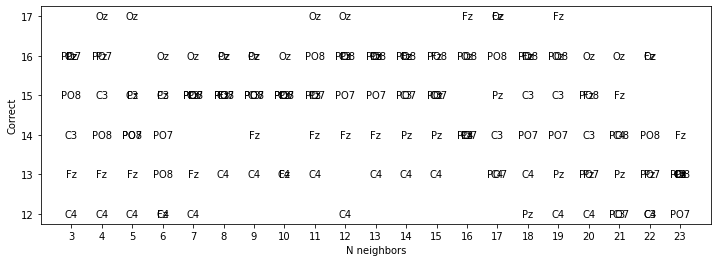

In [26]:
all_res = []
for i in range(3, 24):
    method = cluster.SpectralClustering(2, affinity='nearest_neighbors',
                                        n_neighbors=i, random_state=42)
    res = []
    for ch_n, ch_name in enumerate(unicorn_ch_names):
        samples = [s[ch_n] for s in chosen_samples['aardvark'] + chosen_samples['cabbage']]
        method.fit(samples)
        preds = method.labels_
        
        true = np.array([0] * len(chosen_samples['aardvark']) + [1] * len(chosen_samples['cabbage']))
        true_inverse = np.abs(true - 1)
        correct = np.max([np.sum(preds == true), np.sum(preds == true_inverse)])
        res.append(correct)
    all_res.append(res)

all_res = np.array(all_res)
    
plt.figure(figsize=(12, 4))
for ch_n, ch_name in enumerate(unicorn_ch_names):
    plt.scatter(range(3, 24), all_res[:, ch_n], label=ch_name, c='#FFFFFF')
    for p in range(0, 21):
        plt.text(p+3, all_res[p, ch_n], ch_name, ha='center', va='center')
plt.xlabel('N neighbors')
plt.xticks(range(3, 24))
plt.ylabel('Correct')
plt.show()

**C4** channel looks to be the most informative (is the subject left-handed?). **Pz** takes the second place.

**C4** measures the right motor cortex. The parietal lobe (**Pz**) integrates sensory information from different modalities. 

### KNN

#### Ball tree, 2 neighbors

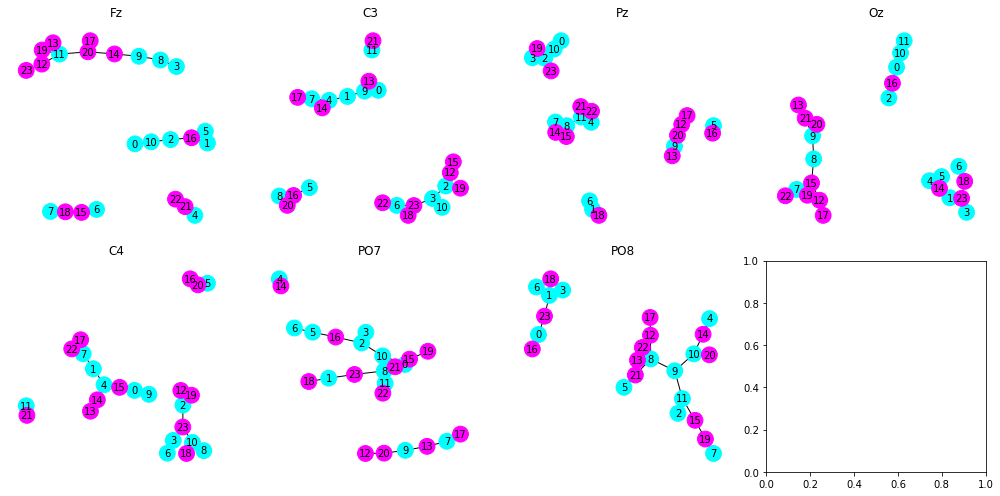

In [28]:
fig, axs = plt.subplots(2, 4, figsize=(14, 7))

for ch_n, (ch_name, ax) in enumerate(zip(unicorn_ch_names, axs.ravel())):
    method = neighbors.NearestNeighbors(n_neighbors=2, algorithm='ball_tree')
    samples = [s[ch_n] for s in chosen_samples['aardvark'] + chosen_samples['cabbage']]
    true = np.array([0] * len(chosen_samples['aardvark']) + [1] * len(chosen_samples['cabbage']))
    method.fit(samples)
    
    dist_graph = method.kneighbors_graph(samples).toarray()
    np.fill_diagonal(dist_graph, 0)  # we are not interested in self-connections
    
    graph = nx.from_numpy_matrix(dist_graph)
    nx.draw(graph, pos=nx.spring_layout(graph), with_labels=True, 
            node_color=true, cmap='cool', 
            font_size=10, node_size=250, ax=ax)
    ax.set_title(f'{ch_name}')
plt.tight_layout()
plt.show()

#### 3 neighbors

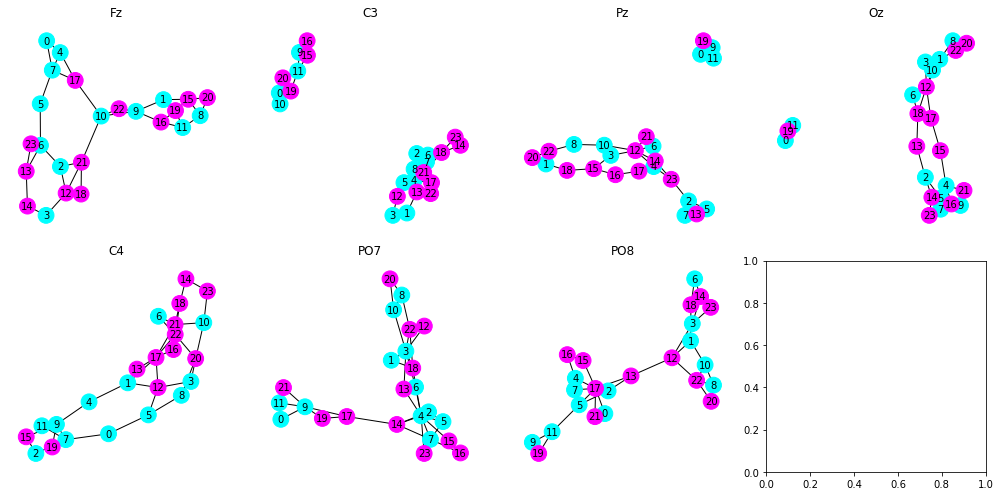

In [21]:
fig, axs = plt.subplots(2, 4, figsize=(14, 7))

for ch_n, (ch_name, ax) in enumerate(zip(unicorn_ch_names, axs.ravel())):
    method = neighbors.NearestNeighbors(n_neighbors=3, algorithm='ball_tree')
    samples = [s[ch_n] for s in chosen_samples['aardvark'] + chosen_samples['cabbage']]
    true = np.array([0] * len(chosen_samples['aardvark']) + [1] * len(chosen_samples['lettuce']))
    method.fit(samples)
    
    dist_graph = method.kneighbors_graph(samples).toarray()
    np.fill_diagonal(dist_graph, 0)  # we are not interested in self-connections
    
    graph = nx.from_numpy_matrix(dist_graph)
    nx.draw(graph, pos=nx.spring_layout(graph), with_labels=True, 
            node_color=true, cmap='cool', 
            font_size=10, node_size=250, ax=ax)
    ax.set_title(f'{ch_name}')
plt.tight_layout()
plt.show()

# Supervised classification (Sklearn)

## Collecting training sets

In [136]:
train_sets = {}

samples = np.array([s[4] for s in chosen_samples['aardvark'] + chosen_samples['cabbage']]) # 4 is Pz
true = np.array([0] * len(chosen_samples['aardvark']) + [1] * len(chosen_samples['cabbage']))
true_inverse = np.abs(true - 1)
labels = ['aardvark', 'cabbage']

### Pz-best and Pz-mistake oriented sets

In [137]:
method = cluster.SpectralClustering(2, affinity='nearest_neighbors',
                                    n_neighbors=12, random_state=42)
method.fit(samples)
preds = method.labels_

In [138]:
chosen_true = true if np.sum(preds == true) > np.sum(preds == true_inverse) else true_inverse
correct_ix = np.where(chosen_true == preds)[0]
incorrect_ix = np.where(chosen_true != preds)[0]
correct_ix

array([ 0,  1,  2,  4,  7,  9, 11, 12, 13, 14, 16, 17, 18, 20, 21, 22, 23],
      dtype=int64)

In [139]:
train_ix = []
for i, label in enumerate(labels):
    first_ix = 0 if i == 0 else len(chosen_samples[labels[0]])
    last_ix = len(chosen_samples[labels[0]]) if i==0 else len(chosen_samples[labels[0]]) + len(chosen_samples[labels[1]])
    ix0 = correct_ix[(first_ix <= correct_ix) & (correct_ix < last_ix)]
    if len(ix0) > len(chosen_samples[label]) // 2:
        train_ix.extend(np.random.choice(ix0, len(chosen_samples[label]) // 2, replace=False))
    else:
        train_ix.extend(ix0)
        train_ix.extend(np.random.choice(incorrect_ix[(first_ix <= incorrect_ix) & (incorrect_ix < last_ix)], 
                        len(chosen_samples[label]) // 2 - len(ix0), replace=False))
        
train_ix = sorted(train_ix)
train_sets['pz_correct'] = {'train': np.array(train_ix), 
                            'test': np.array([i for i in range(len(samples)) if i not in train_ix])}

print(train_sets['pz_correct'])

{'train': array([ 0,  1,  2,  4,  7, 11, 12, 13, 14, 17, 21, 23], dtype=int64), 'test': array([ 3,  5,  6,  8,  9, 10, 15, 16, 18, 19, 20, 22])}


In [140]:
train_ix = []
for i, label in enumerate(labels):
    first_ix = 0 if i == 0 else len(chosen_samples[labels[0]])
    last_ix = len(chosen_samples[labels[0]]) if i==0 else len(chosen_samples[labels[0]]) + len(chosen_samples[labels[1]])
    ix0 = incorrect_ix[(first_ix <= incorrect_ix) & (incorrect_ix < last_ix)]
    if len(ix0) > len(chosen_samples[label]) // 2:
        train_ix.extend(np.random.choice(ix0, len(chosen_samples[label]) // 2, replace=False))
    else:
        train_ix.extend(ix0)
        train_ix.extend(np.random.choice(correct_ix[(first_ix <= correct_ix) & (correct_ix < last_ix)], 
                        len(chosen_samples[label]) // 2 - len(ix0), replace=False))
        
train_ix = sorted(train_ix)
train_sets['pz_incorrect'] = {'train': np.array(train_ix), 
                            'test': np.array([i for i in range(len(samples)) if i not in train_ix])}

print(train_sets['pz_incorrect'])

{'train': array([ 1,  3,  5,  6,  8, 10, 14, 15, 18, 19, 20, 21], dtype=int64), 'test': array([ 0,  2,  4,  7,  9, 11, 12, 13, 16, 17, 22, 23])}


### Random sets

In [141]:
rng = np.random.default_rng(42)

for r in range(3):
    train_ix = []
    for i, label in enumerate(labels):
        train_ix.extend(np.random.choice(np.where(true==i)[0], len(chosen_samples[labels[i]]) // 2, replace=False))
    train_sets[f'random_{r}'] = {'train': np.array(train_ix), 
                                 'test': np.array([i for i in range(len(samples)) if i not in train_ix])}
    
print(train_sets['random_0'])

{'train': array([ 2,  5,  0,  3,  8, 10, 12, 14, 15, 19, 16, 21], dtype=int64), 'test': array([ 1,  4,  6,  7,  9, 11, 13, 17, 18, 20, 22, 23])}


## Visualizing training sets

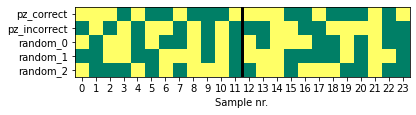

In [142]:
all_trains = [train_sets[set_name]['train'] for set_name in train_sets.keys()]
train_mat = np.zeros((len(all_trains), 24))
for i, train in enumerate(all_trains):
    train_mat[i, train] = 1

plt.xticks(range(24))
plt.yticks(range(len(all_trains)), labels=train_sets.keys())
plt.plot([11.5, 11.5], [-1, len(all_trains)], lw=3, c='k')
plt.imshow(train_mat, cmap='summer')
plt.xlabel('Sample nr.')
plt.show()

## Getting results

Ridge
pz_correct


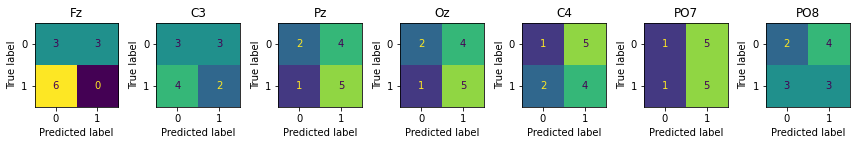

pz_incorrect


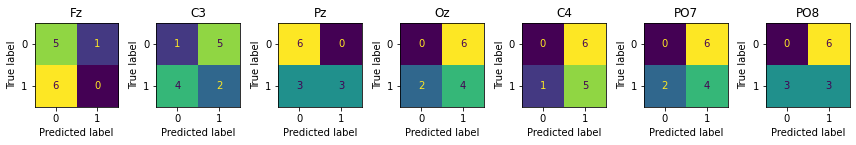

random_0


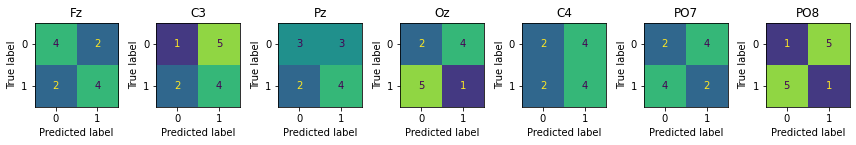

random_1


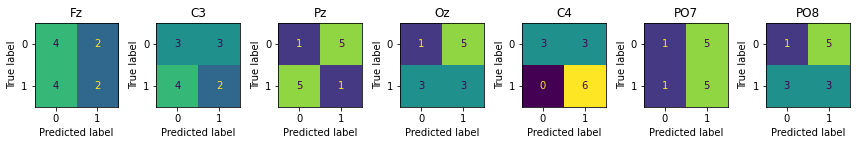

random_2


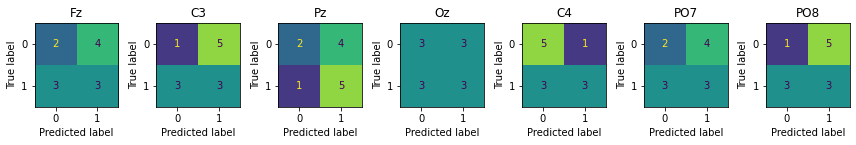

Logistic
pz_correct


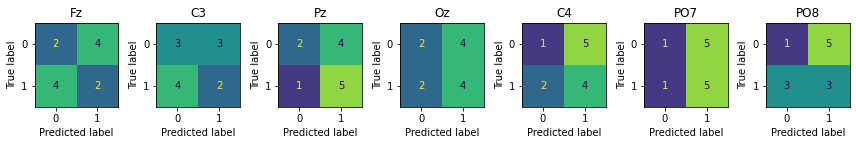

pz_incorrect


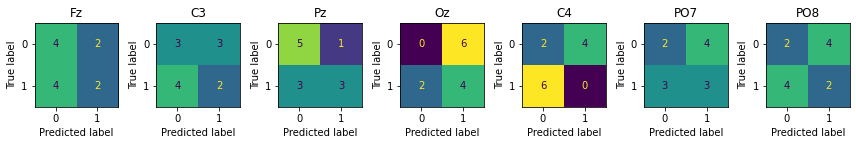

random_0


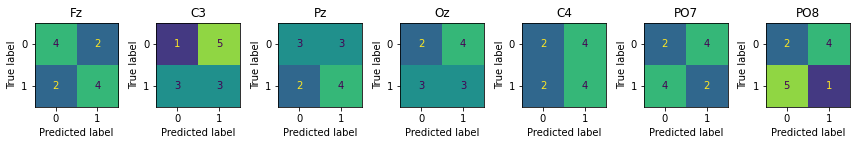

random_1


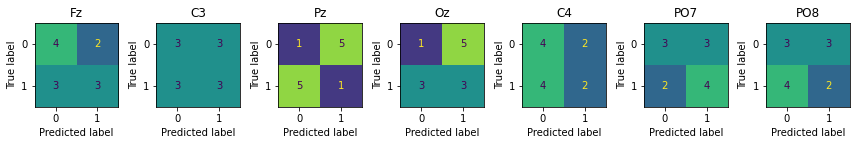

random_2


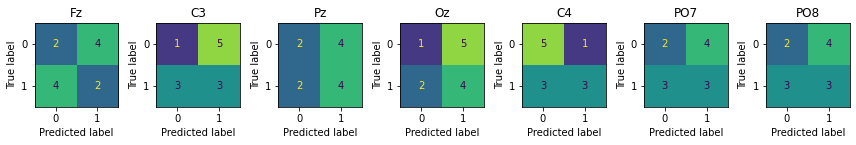

SGD
pz_correct


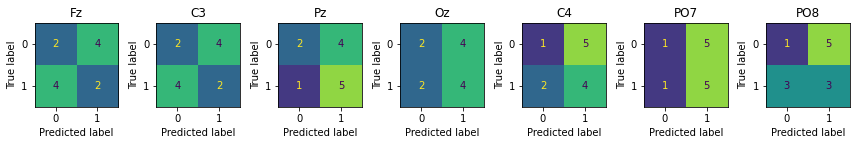

pz_incorrect


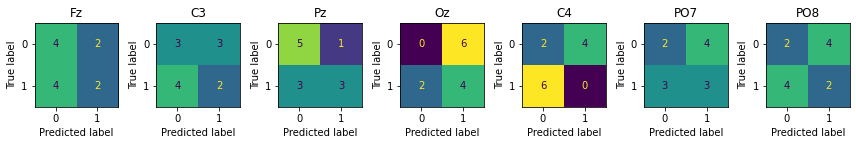

random_0


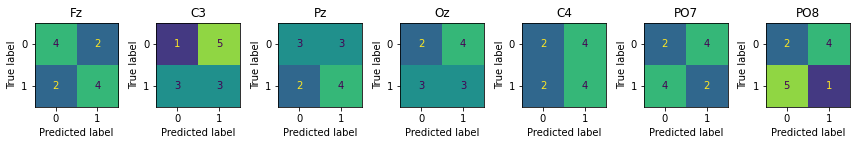

random_1


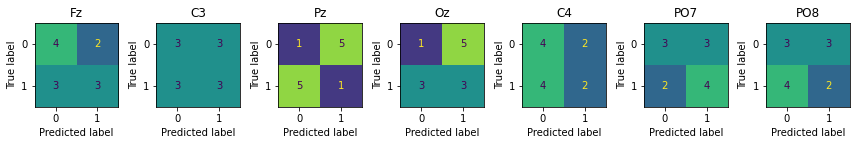

random_2


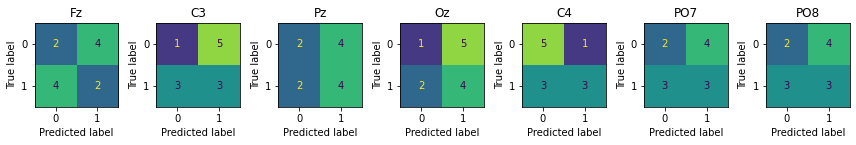

Perceptron
pz_correct


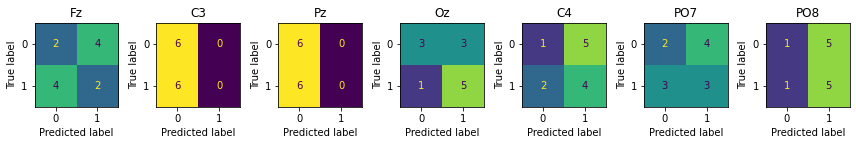

pz_incorrect


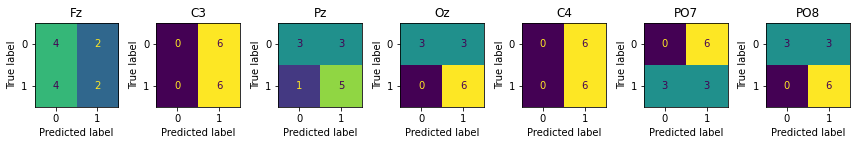

random_0


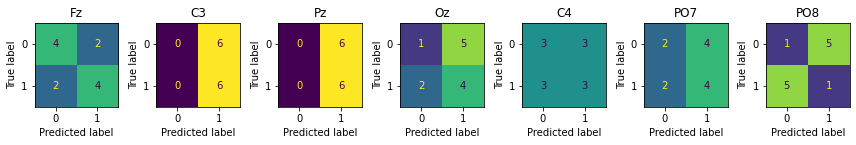

random_1


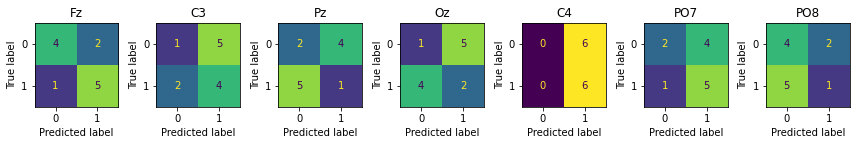

random_2


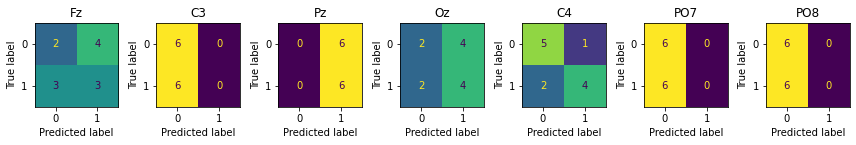

SVC
pz_correct


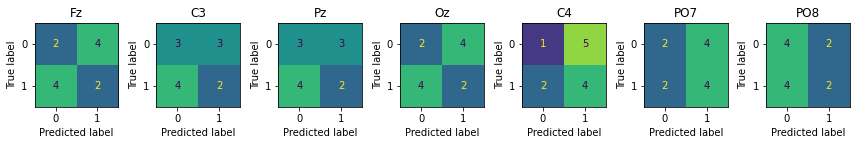

pz_incorrect


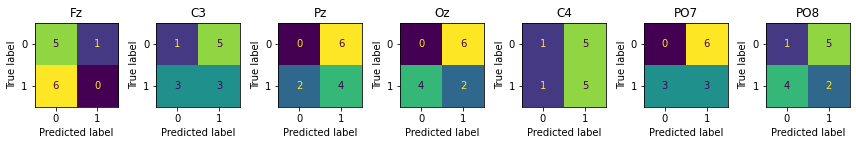

random_0


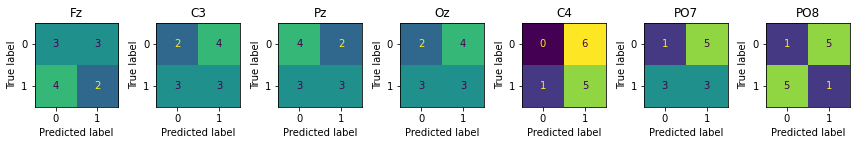

random_1


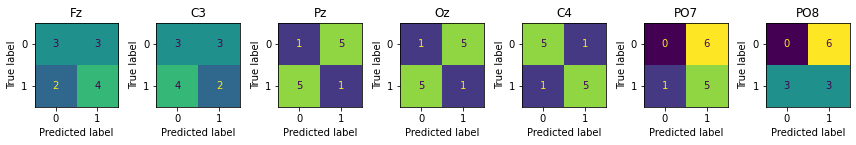

random_2


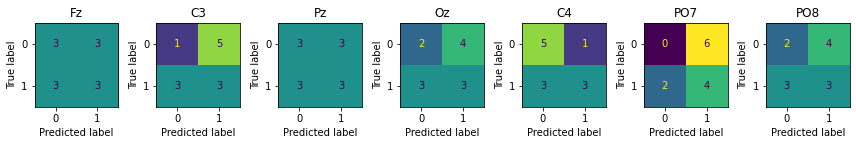

In [143]:
methods = {
    'Ridge': linear_model.RidgeClassifier(alpha=1),
    'Logistic': linear_model.LogisticRegression(solver='liblinear', penalty='l2'),
    'SGD': linear_model.SGDClassifier(learning_rate='adaptive', eta0=0.1),
    'Perceptron': linear_model.Perceptron(),
    'SVC': svm.SVC(kernel='rbf')
}
true_labels = np.array([0]*6 + [1]*6)  # un-hardcore

for method_name, method in methods.items():
    print(method_name)
    for set_name, train_set in train_sets.items():
        print(set_name)
        fig, ax = plt.subplots(1, 7, figsize=(12, 3))
        for ch_n, ch_name in enumerate(unicorn_ch_names):
            samples = np.array([s[ch_n] for s in chosen_samples['aardvark'] + chosen_samples['cabbage']])
            method.fit(samples[train_set['train']], true_labels)
            preds = method.predict(samples[train_set['test']])
            disp = ConfusionMatrixDisplay.from_predictions(true_labels, preds,
                                                    colorbar=False,                                                
                                                    ax=ax[ch_n])
            disp.im_.set_clim(0, 6)
            ax[ch_n].set_title(ch_name)
        plt.tight_layout()
        plt.show() 

Although `Pz` channel was the best for unsupervised classification, it is the worst for supervised classification when concnetrating on badly clustered samples (zero correct predictions). This means that clustering sees something in "bad" Pz samples which is very different from "good" Pz samples.

# Convert time series to spectral+time series with Wavelet Transform

In [144]:
def morlet_wavelet_transform(x, fs, min_freq, max_freq, freq_step=1, w=5):
    freqs = np.linspace(min_freq, max_freq, (max_freq-min_freq)//freq_step)
    widths = w*fs / (2 * freqs * np.pi)
    res = signal.cwt(x, signal.morlet2, widths, w=w)
    return np.real(res)

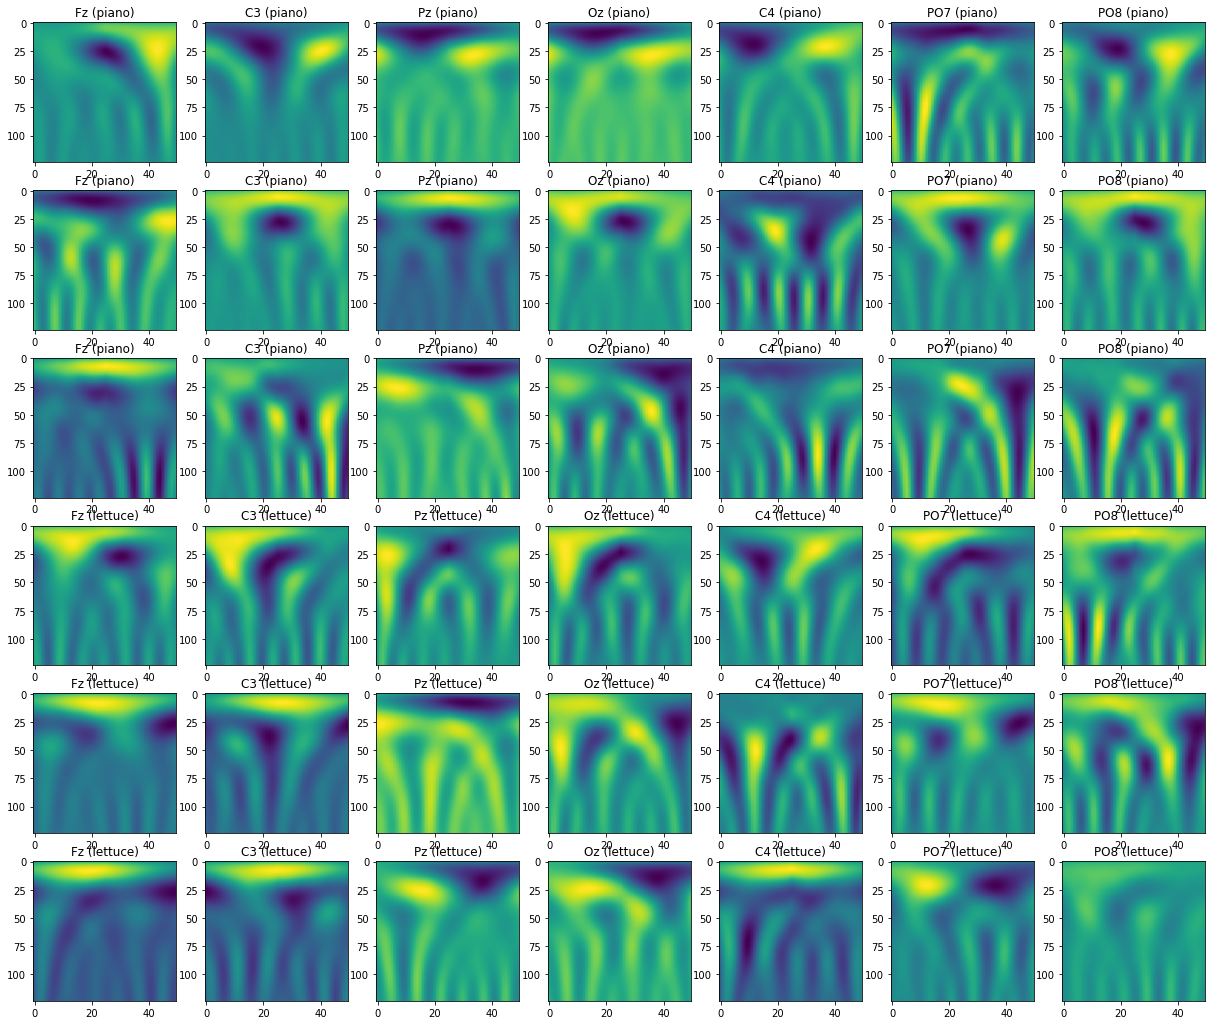

In [145]:
fig, ax = plt.subplots(6, 7, figsize=(21, 18))
vmin, vmax = 0, 0
for i, label in enumerate(labels):
    for ch_n, ch_name in enumerate(unicorn_ch_names):
        for j in range(3):
            sample = chosen_samples[label][j][ch_n]
            transformed = morlet_wavelet_transform(sample, fs=1000, min_freq=1, max_freq=125, freq_step=1, w=5)
            ax[i*3+j, ch_n].imshow(transformed, aspect='auto')
            ax[i*3+j, ch_n].set_title(f'{ch_name} ({label})')
            vmin = np.min([vmin, np.min(transformed)])
            vmax = np.max([vmax, np.max(transformed)])
for im in plt.gca().get_images():
    im.set_clim(vmin, vmax)
            
plt.show()          

In [146]:
wavelets = {}
for i, label in enumerate(labels):
    wavelets[label] = {}
    for ch_n, ch_name in enumerate(unicorn_ch_names):
        wavelets[label][ch_name] = []
        samples = [s[ch_n] for s in chosen_samples[label]]
        for sample in samples:
            transformed = morlet_wavelet_transform(sample, fs=1000, min_freq=1, max_freq=125, freq_step=1, w=5)
            wavelets[label][ch_name].append(transformed)

# Try convolutional layer on wavelet data

tensor([[0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287]], grad_fn=<AddmmBackward0>) tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
tensor([[0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287]], grad_fn=<AddmmBackward0>) tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
tensor([[0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287],
        [0.0421, 0.0287]

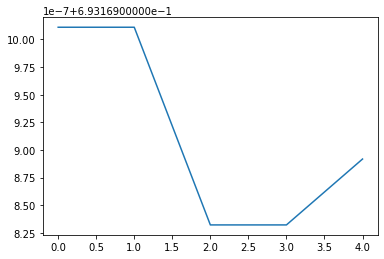

In [171]:
## DOES NOT LEARN, THERE IS SOME ERROR?

# model = nn.Sequential(nn.Conv1d(50, 1, kernel_size=5), nn.ReLU(),
#                       nn.Flatten(), 
#                       nn.Linear(120, 2))

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-6)

# labels_0 = train_sets['random_0']['train'][:6]
# labels_1 = train_sets['random_0']['train'][6:] - 12
# x = np.vstack((np.array(wavelets['piano']['C4'])[labels_0], np.array(wavelets['lettuce']['C4'])[labels_1]))
# x = Tensor(x).permute(0, 2, 1)
# y = LongTensor(np.array([0] * 6 + [1] * 6))

# losses = []

# model.train()
# for epoch in range(5):   
#     optimizer.zero_grad()
#     outputs = model(x)
#     loss = criterion(outputs, y)
#     print(outputs, y)
#     loss.backward()
#     losses.append(loss.item())
#     optimizer.step()

# plt.plot(losses)